# 2022-05-13 • A Network

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [26]:
p = ExperimentParams(sim=NetworkSimParams());
# dumps(p)

## Run sim

In [27]:
state = sim(p.sim);

Running simulation: 100%|███████████████████████████████| Time: 0:00:05


In [31]:
num_spikes = length.(state.rec.spike_times)

ComponentVector{Int64}(exc = [7, 9, 2, 4, 1, 6, 8, 5, 5, 3  …  5, 5, 4, 5, 5, 5, 6, 9, 6, 7], inh = [6, 1, 1, 3, 1, 2, 1, 3, 1, 2  …  2, 1, 2, 3, 4, 1, 0, 3, 2, 1])

In [19]:
import PyPlot

In [8]:
using VoltoMapSim.Plot

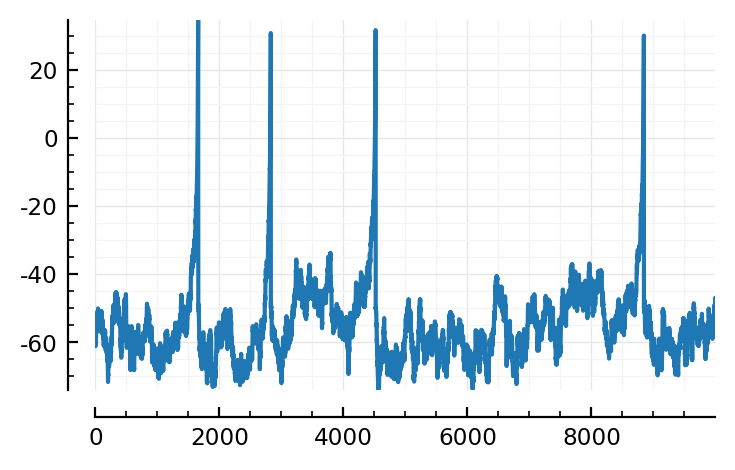

In [30]:
plot(state.rec.voltage_traces[1] / mV);

In [33]:
VI_sigs = add_VI_noise(state, NetworkSimParams(), noisy_VI);

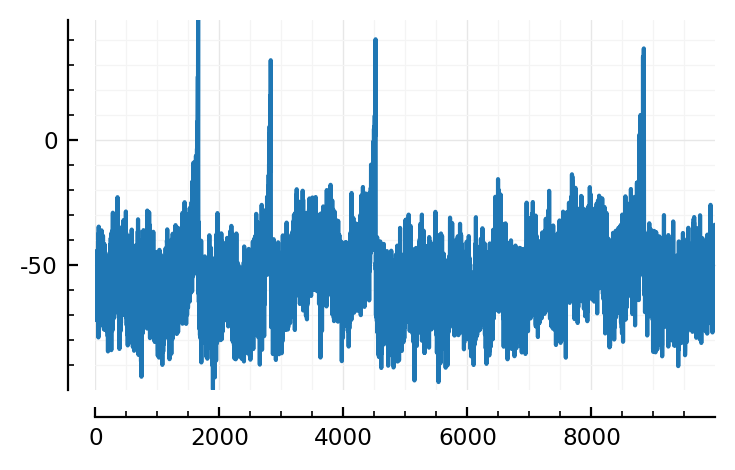

In [34]:
plot(VI_sigs[1] / mV);

## Plot sim